0
Done


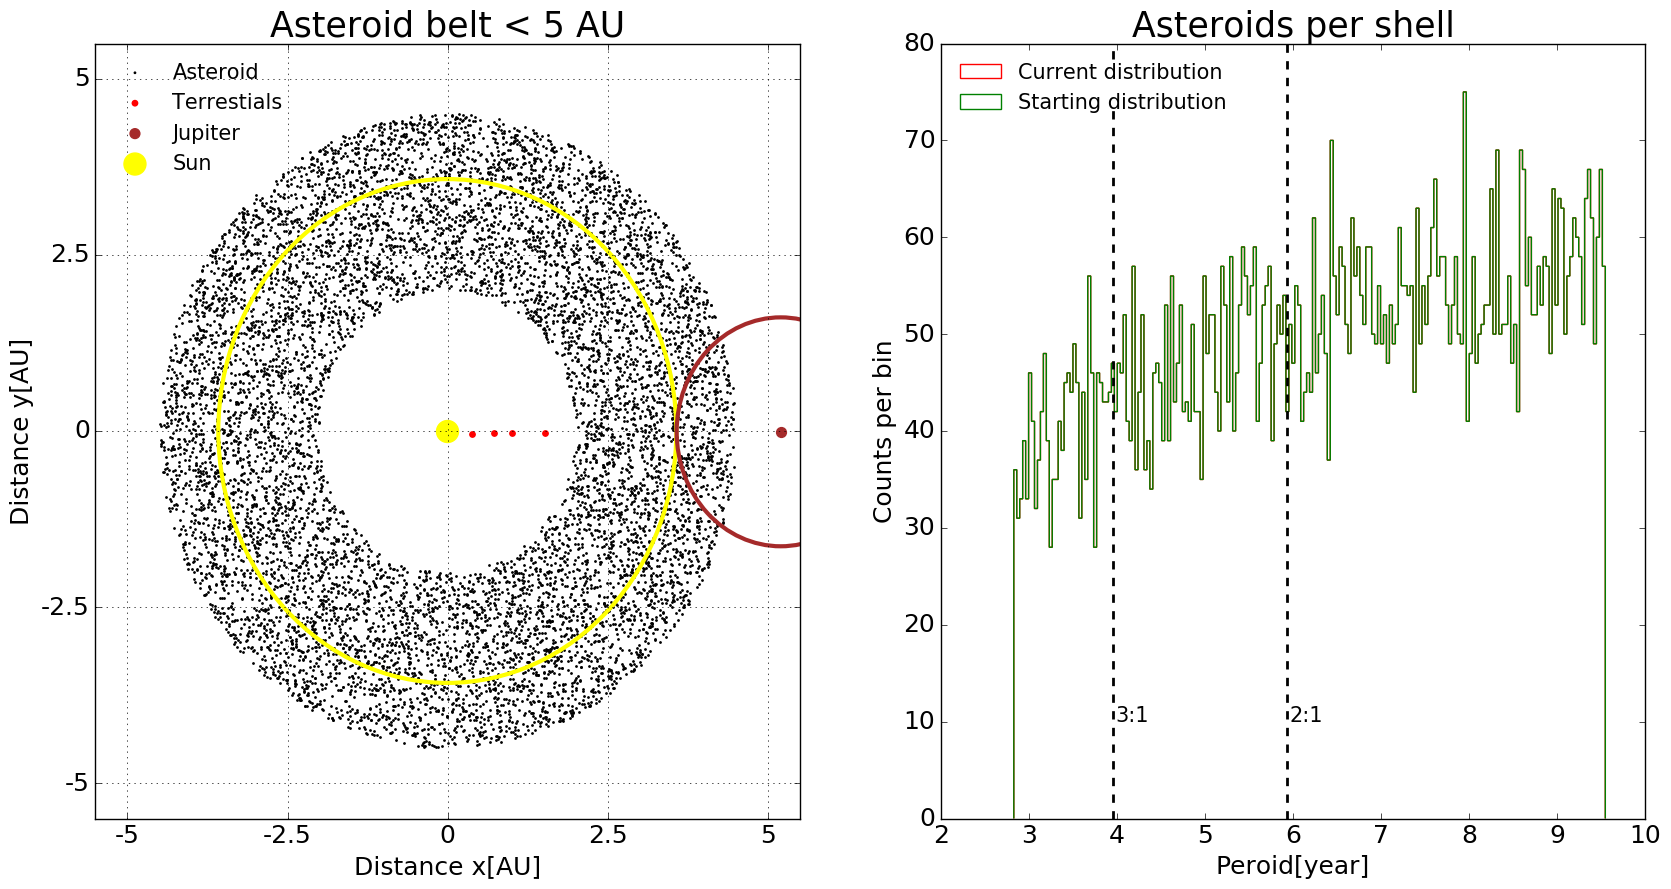

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
import pylab as pl
import math
import matplotlib
%matplotlib inline


 # meters, com = center of mass
period_jup_around_sun = 11.86#year #4332.59 * 24 * 3600 # s

G = 6.67*10**(-11) #SI units
G = 4 * np.pi**2
m_sun = 2*10**30 #kg
m_sun = 1
m_jup = 1.898*10**27 #kg
m_jup = 0.0009543
AU = 1.496*10**11 #m
distance_sun_com_with_jupiter = 742000000
distance_sun_com_with_jupiter = distance_sun_com_with_jupiter/AU
AU=1

dt = 3600*24 #s
dt = 0.004224537
N = 10000#unitless
tijd = 1000 #dag
plotting_time_stepsize = 1000


inner_r = 2 #AU
outer_r = 4.5 #AU
inner_r_au = inner_r * AU
outer_r_au = outer_r * AU
r_max_kwad = outer_r**2 #AU^2
r_min_kwad = inner_r**2 #AU^2
discard_asteroid_limit = 6 * AU

pos_jup_start = np.array([5.2 * AU,0,0]) #m
pos_sun_start = np.array([-distance_sun_com_with_jupiter,0,0]) #m





def sun_start(pos_sun_start): 
    '''
    Function accepts startpositions of sun and returns them in an array.
    Calculates starting velocities along the way using the positions.
    '''
    x_sun_start,y_sun_start,z_sun_start = pos_sun_start # Starting x,y,z
    theta_sun = math.atan2(y_sun_start,x_sun_start) # To derive the components of vx, vy and vz
    d_sun_to_com = np.sqrt(x_sun_start**2 + y_sun_start**2) # Distance to center of mass
    
    v_sun = (2 * np.pi * distance_sun_com_with_jupiter)/(period_jup_around_sun)
    vx_sun = v_sun * np.sin(theta_sun)
    vy_sun = -v_sun * np.cos(theta_sun)
    vz_sun = 0
    pos_sun_start = np.array([x_sun_start, y_sun_start, z_sun_start, vx_sun, vy_sun, vz_sun])
    return pos_sun_start


def planet_start(pos_planet_start):
    '''
    Function accepts startpositions of planets and returns them in an array.
    Calculates starting velocities along the way using the positions.
    '''
    x_planet, y_planet, z_planet = pos_planet_start
    theta_planet = math.atan2(y_planet, x_planet)
    d_planet_to_sun = np.sqrt(x_planet**2 + y_planet**2) # Ignoring displacement sun
    v_planet = np.sqrt(G * m_sun/d_planet_to_sun)
    vx_planet = v_planet * np.sin(theta_planet)
    vy_planet = - v_planet * np.cos(theta_planet)
    vz_planet = 0
    pos_planet_start = np.array([x_planet, y_planet, z_planet, vx_planet, vy_planet, vz_planet])
    return pos_planet_start



# They'll go clockwise!
def startvalue_generator(N):
    '''
    Function accepts the number of asteroids in the belt.
    Calculates random starting positions and computes their velocity using x, y and z.
    Returns the 6xN variable matrix.
    '''
    s = (6,N)
    start_pos_array = np.zeros(s)
    N_succeed = 0
    while N_succeed < N:
        x = random.uniform(-outer_r, outer_r) 
        y = random.uniform(-outer_r, outer_r)
        if x**2 + y**2 <= r_max_kwad and x**2 + y**2 >= r_min_kwad: # To restrain them in the belt
            x = x * AU
            y = y * AU
            z = 0
            d = np.sqrt(x**2 + y**2)
            v = np.sqrt(G*m_sun/d)
            theta = math.atan2(y,x)
            vx = v * np.sin(theta)
            vy = -v * np.cos(theta)
            vz = 0
            start_pos = np.array([x, y, z, vx, vy, vz])
            start_pos_array[:,N_succeed] = start_pos
            N_succeed = N_succeed + 1
    return start_pos_array
    
    
def planet_position(pos_planet, pos_sun):
    '''
    Accepts last position of planet and sun.
    Computes the new velocity components + positions using dynamics and Euler-Cromer.
    Returns array of new velocity + positions.
    '''
    x_sun, y_sun, z_sun, vx_sun, vy_sun, vz_sun = pos_sun
    planet_x_last, planet_y_last, planet_z_last, planet_vx_last, planet_vy_last, planet_vz_last = pos_planet
    sun_constant = (-G * m_sun)/((np.sqrt((planet_x_last - x_sun)**2 + (planet_y_last - y_sun)**2 + (planet_z_last - z_sun)**2))**3)
    a_x = sun_constant * (planet_x_last - x_sun)
    a_y = sun_constant * (planet_y_last - y_sun)
    a_z = sun_constant * (planet_z_last - z_sun)
    planet_vx_new = planet_vx_last + a_x *dt
    planet_vy_new = planet_vy_last + a_y *dt
    planet_vz_new = planet_vz_last + a_z *dt
    planet_x_new = planet_x_last + planet_vx_new * dt
    planet_y_new = planet_y_last + planet_vy_new * dt
    planet_z_new = planet_z_last + planet_vz_new * dt
    pos_planet = np.array([planet_x_new, planet_y_new, planet_z_new, planet_vx_new, planet_vy_new, planet_vz_new])
    return pos_planet



def sun_position(sun_pos, jup_pos):
    '''
    Accepts last position of Jupiter and the sun.
    Computes the new velocity components + positions using dynamics and Euler-Cromer.
    Sun circles around common center of mass
    Returns array of new velocity + positions.
    '''
    sun_x_last, sun_y_last, sun_z_last, sun_vx_last, sun_vy_last, sun_vz_last = sun_pos
    jup_x_last, jup_y_last, jup_z_last, jup_vx_last, jup_vy_last, jup_vz_last = jup_pos
    jup_constant = (-G * m_jup)/((np.sqrt((sun_x_last - jup_x_last)**2 + (sun_y_last - jup_y_last)**2 + (sun_z_last - jup_z_last)**2))**3)
    a_x = jup_constant * (sun_x_last - jup_x_last)
    a_y = jup_constant * (sun_y_last - jup_y_last)
    a_z = jup_constant * (sun_z_last - jup_z_last)
    vx_sun = sun_vx_last + a_x *dt
    vy_sun = sun_vy_last + a_y *dt
    vz_sun = sun_vz_last + a_z *dt
    x_sun = sun_x_last + vx_sun * dt
    y_sun = sun_y_last + vy_sun * dt
    z_sun = sun_z_last + vz_sun * dt
    sun_pos = np.array([x_sun, y_sun, z_sun, vx_sun, vy_sun, vz_sun])
    return sun_pos


def euler_cromer(pos_array, pos_sun, pos_jup):    
    '''
    Accepts last position of Jupiter, the asteroid and the sun.
    Computes the new velocity components + positions using dynamics and Euler-Cromer.
    Asteroid circles around sun, under influence of Jupiter.
    Returns array of new velocity + positions.
    '''
    x_last, y_last, z_last, vx_last, vy_last, vz_last = pos_array
    x_sun, y_sun, z_sun, vx_sun, vy_sun, vz_sun = pos_sun
    x_jup, y_jup, z_jup, vx_jup, vy_jup, vz_jup = pos_jup
    sun_constant = (-G * m_sun)/((np.sqrt((x_last - x_sun)**2 + (y_last - y_sun)**2 + (z_last - z_sun)**2))**3)
    jup_constant = (-G * m_jup)/((np.sqrt((x_last - x_jup)**2 + (y_last - y_jup)**2 + (z_last - z_jup)**2))**3)    
    a_x = sun_constant * (x_last - x_sun) + jup_constant * (x_last - x_jup)
    a_y = sun_constant * (y_last - y_sun) + jup_constant * (y_last - y_jup)
    a_z = sun_constant * (z_last - z_sun) + jup_constant * (z_last - z_jup)    
    vx_new = vx_last + a_x * dt
    vy_new = vy_last + a_y * dt
    vz_new = 0     
    x_new = x_last + vx_new * dt
    y_new = y_last + vy_new * dt
    z_new = z_last  
    new_pos_tuple = np.array([x_new, y_new, z_new, vx_new, vy_new, vz_new])
    return new_pos_tuple


def asteroids(tijd):
    '''
    Master function that accepts the length of the simulation.
    Calls on functions that compute new positions per timestep.
    Plots the situation once in every X computations.
    Removes asteroids that are out of the belt from the calculations.
    Returns histograms and 2D situation plot.
    '''
    f, axs = plt.subplots(2,2,figsize=(20,10))
    
    pos_array = startvalue_generator(N)    
    pos_sun = sun_start(pos_sun_start)
    pos_jup = planet_start(pos_jup_start)
    pos_merc = planet_start([.39*AU,0,0])
    pos_ven = planet_start([.72*AU,0,0])
    pos_earth = planet_start([1.0*AU,0,0])
    pos_mars = planet_start([1.52*AU,0,0])
    
    mu = G * m_sun
    for t in range(tijd):
        pos_array = euler_cromer(pos_array, pos_sun, pos_jup)
        pos_sun = sun_position(pos_sun, pos_jup)
        x_sun, y_sun, z_sun, vx_sun, vy_sun, vz_sun = pos_sun
        pos_jup = planet_position(pos_jup, pos_sun)
        pos_merc = planet_position(pos_merc, pos_sun)
        pos_ven =  planet_position(pos_ven, pos_sun)
        pos_earth =  planet_position(pos_earth, pos_sun)
        pos_mars =  planet_position(pos_mars, pos_sun)
        if t == 0:
            r_original_array = np.sqrt(pos_array[0]**2 + pos_array[1]**2)
            v_original_array = np.sqrt(pos_array[3]**2 + pos_array[4]**2)
            T_original_array = 2 * np.pi * mu * np.sqrt((-r_original_array**3)/((r_original_array * v_original_array**2 - 2 * mu)**3))
            T_original_array = T_original_array[~np.isnan(T_original_array)]
        if t % plotting_time_stepsize == 0:
            
            
            # Killing off far away asteroids
            del_array = pos_array[0] < discard_asteroid_limit
            x, y, z, vx, vy, vz = pos_array
            x = x[del_array]
            y = y[del_array]
            z = z[del_array]
            vx = vx[del_array]
            vy = vy[del_array]
            vz = 0
            pos_array = np.array([x,y,z,vx,vy,vz])    
            
            del_array2 = pos_array[1] < discard_asteroid_limit
            x, y, z, vx, vy, vz = pos_array
            x = x[del_array2]
            y = y[del_array2]
            z = z[del_array2]
            vx = vx[del_array2]
            vy = vy[del_array2]
            vz = 0
            pos_array = np.array([x,y,z,vx,vy,vz])
            
            
            r_array = np.sqrt(pos_array[0]**2 + pos_array[1]**2)
            v_array = np.sqrt(pos_array[3]**2 + pos_array[4]**2)
            T_array = 2 * np.pi * mu * np.sqrt((-r_array**3)/((r_array * v_array**2 - 2 * mu)**3))
            T_array = T_array[~np.isnan(T_array)]
            
            T_array = T_array[T_array<=10] # All out of jupiters orbit: gone from plot
            T_array = T_array[T_array>=2]
            
            # From here on plotting only
            f.clear()
            plt.subplot(121)
            plt.scatter(pos_merc[0], pos_merc[1], s = 15, color = 'red')
            plt.scatter(pos_ven[0], pos_ven[1], s = 15, color = 'red')
            plt.scatter(pos_earth[0], pos_earth[1], s = 15, color = 'red')
            plt.scatter(pos_array[:][0], pos_array[:][1], s = 1, color = 'black', label = 'Asteroid')
            plt.scatter(pos_mars[0], pos_mars[1], s = 15, color = 'red', label = 'Terrestials')
            plt.scatter(pos_jup[0], pos_jup[1], s = 50, color = 'brown', label = 'Jupiter')
            plt.scatter(pos_sun[0], pos_sun[1], s = 250, color = 'yellow', label = 'Sun')
            roche_sun = plt.Circle((pos_sun[0], pos_sun[1]), 3.5755, color='yellow', fill=False, linewidth = 3)
            plt.gca().add_artist(roche_sun)
            roche_jup = plt.Circle((pos_jup[0], pos_jup[1]), 1.6245, color='brown', fill=False, linewidth = 3)
            plt.gca().add_artist(roche_jup)
            plt.title('Asteroid belt < 5 AU', fontsize = 25)
            plt.xlabel('Distance x[AU]', fontsize = 18)
            plt.ylabel('Distance y[AU]', fontsize = 18)
            plt.xlim([-5.5*AU,5.5*AU])
            plt.ylim([-5.5*AU,5.5*AU])
            xset = [-5 * AU, -2.5 * AU, 0, 2.5 * AU, 5 * AU]
            yset = [-5 * AU, -2.5 * AU, 0, 2.5 * AU, 5 * AU]
            labels = ['-5', '-2.5', '0', '2.5', '5']
            plt.xticks(xset, labels, rotation='horizontal', fontsize = 18)
            plt.yticks(yset, labels, rotation='horizontal', fontsize = 18)
            plt.legend(loc = 2, scatterpoints = 1, frameon = False, fontsize = 15)
            plt.grid()

            
            plt.subplot(122)
            plt.hist(T_array, bins = 200, histtype = 'step', color = 'red', label = 'Current distribution')
            plt.hist(T_original_array, bins = 200, histtype = 'step', color = 'green', label = 'Starting distribution')
            plt.axvline(5.93, 0,1,linestyle = 'dashed', linewidth = 2, color = 'black')
            plt.text(5.96,10,'2:1',fontsize = 15)
            plt.axvline(3.95, 0,0.915,linestyle = 'dashed', linewidth = 2, color = 'black')
            plt.axvline(3.95, 0.98,1,linestyle = 'dashed', linewidth = 2, color = 'black')
            plt.text(3.98,10,'3:1',fontsize = 15)
            plt.title('Asteroids per shell', fontsize = 25)
            plt.xlabel('Peroid[year]', fontsize = 18)
            plt.ylabel('Counts per bin', fontsize = 18)
            plt.xlim([2,10])
            plt.xticks(fontsize = 18)
            plt.yticks(fontsize = 18)
            plt.legend(loc = 2, frameon = False, fontsize = 15)
            display.display(pl.gcf())
            
            display.clear_output(wait=True)
            
            time.sleep(2)
            print 'Days spent:', t

    return 'Done'

print asteroids(tijd)